In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom
from scipy.optimize import minimize
from pathlib import Path


In [55]:
def logNormal_MLE_fit(num_occurences, num_trials, x_values):
    """
    fits a log normal distribution to the provided data. returns the
    distribution median and the dispersion. The inputs are vectors. each index
    of the vector is treated as an independent set of bernoulli trials,
    (Binomial distribution). x_values is independent variable that changes
    between each of the binomial distributions. I.e. for fragility curve fitting
    x_values is the IM level of each set of data

    Args:
        num_occurences (np.array): number of occurence of a phenomenon.
        num_trials (np.array): number of trials in each test.
        x_values (np.array): x axis values corresponding to each trial.

    Returns:
        theta (float): distribution median.
        beta (float): distributio dispersion.
        scs (TYPE): flag for successful solution from solver.

    """
    # starting guess for the theta/beta values. Assumes that there are at
    # least three points for fit. theta = middle value, beta = 0.5
    x0 = [x_values[3], 0.4]

    # set the max/min bounds on theta and beta
    theta_min = 0.01*x_values[0]
    theta_max = None
    beta_min = 0
    beta_max = None

    args = np.array([num_occurences, num_trials, x_values])
    bounds = ((theta_min, theta_max), (beta_min, beta_max))

    # Minimise the likelihood function
    sol = minimize(logNormal_likelihood, x0, args=args,
                   options={'maxiter': 10000}, bounds=bounds, method=None)

    theta = sol.x[0]
    beta = sol.x[1]
    scs = sol.success

    return theta, beta, scs


def logNormal_likelihood(x0, *args):
    """
    Lognormal likelihood function calculated as described in:
        Baker (2015), Efficient analytical fragility function fitting
        using dynamic structural analysis, Earthquake Spectra, V.31,
        No.1, pg 579-599

    Args:
        x0 (list/tup): initial guesses for (theta, beta). Median/dispersion
        *args (list): tuple/list of lists containing.
            zs = number of occurences
            ns = number of trials
            xj = x value (e.g. IM for a collapse fragility function)

    Raises:
        ValueError: the input vectors are not the same length.

    Returns:
        float: inverse of the likelihood function.

    """
    theta = x0[0]
    beta = x0[1]

    zs = np.array(args[0][0])
    ns = np.array(args[0][1])
    xs = np.array(args[0][2])

    # check vectors are the same length
    if not sameLength([zs, ns, xs]):
        raise ValueError('Input vectors zs, ns, xs are not the same length')

    # When the data is obtained for multiple x values (e.g. IM levels) the
    # likelihood of the entire set is the product of the binomial probability
    # at each x value

    # probability [pj] is defined using the logNormal CDF
    ps = norm.cdf(np.log(xs/theta)/beta)

    # binomial probabilities for each x based on n trials and z occurences
    # and p probability
    binom_ps = []
    for zj, nj, pj in zip(zs, ns, ps):
        binom_ps.append(binom.pmf(zj, nj, pj))
    binom_ps = np.array(binom_ps)

    # taking the log of the binomial probabilities allows summation
    L = sum(np.log(binom_ps))

    # return 1/L so that the function can be minimsed to get the
    # parameter estimates
    return 1/L
    
    
def sameLength(vector_list):
    # takes a list of vectors and checks that they are all the same length
    # returns True or False.

    lengths = [len(vec) for vec in vector_list]
    result = all(length == lengths[0] for length in lengths)

    return result

C:\Users\Nicholas Clemett\AppData\Local\Temp\ipykernel_4312\1664654626.py:82: RuntimeWarning: divide by zero encountered in divide
  ps = norm.cdf(np.log(xs/theta)/beta)
C:\Users\Nicholas Clemett\AppData\Local\Temp\ipykernel_4312\1664654626.py:92: RuntimeWarning: divide by zero encountered in log
  L = sum(np.log(binom_ps))


True
True
True
True
True
True
True
True
True
True


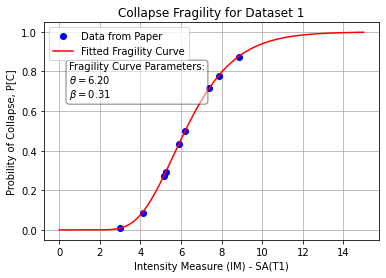

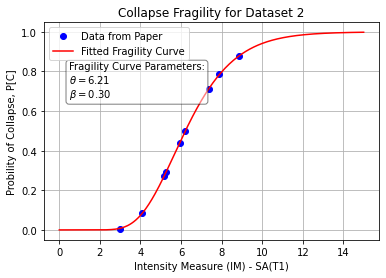

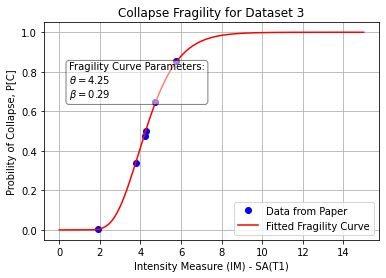

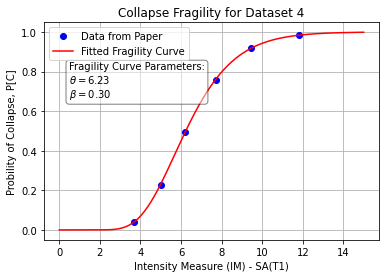

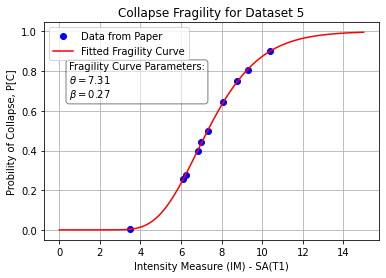

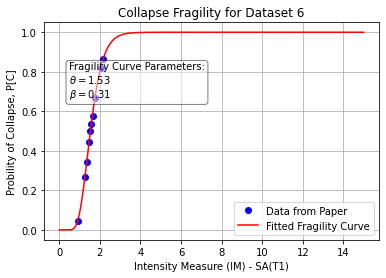

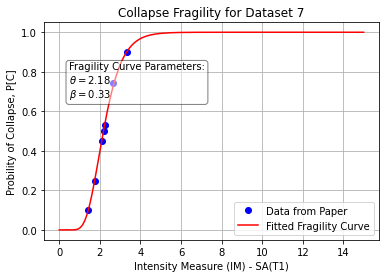

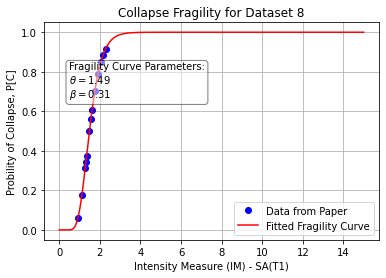

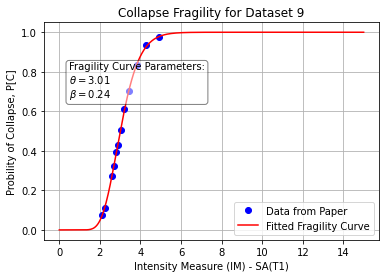

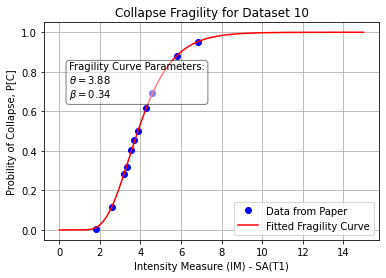

In [56]:
im_max = 15
data_folder = Path(os.getcwd()) / "tartaglia_fcs"
files = os.listdir(data_folder)
# files = ["Dataset_test.csv"]

for ii, f in enumerate(files):

    file_path = data_folder / f  
    data = np.loadtxt(file_path, delimiter=",")

    IMs = data[:,0]
    pCs = data[:,1]
    n_trials = 1000 * np.ones(len(IMs))
    n_occurences = pCs*1000
    theta, beta, scs = logNormal_MLE_fit(n_occurences, n_trials, IMs)
    print(scs)

    # calculate cdf
    cts_IMs = np.linspace(0.001, im_max, 300)
    fragility = norm.cdf((np.log(cts_IMs/theta))/beta)

    # plot collapse data and fitted curve
    plt.figure()
    plt.plot(IMs, pCs, 'ob', label='Data from Paper')
    plt.plot(cts_IMs, fragility, '-r', label='Fitted Fragility Curve')
    # plt.xlim((0, 0.8))
    # plt.ylim((0, 1.0))
    plt.title(f'Collapse Fragility for Dataset {ii+1}')
    plt.ylabel('Probility of Collapse, P[C]')
    plt.xlabel('Intensity Measure (IM) - SA(T1)')
    plt.grid(True, 'both', 'both')
    plt.legend()
    ax = plt.gca()

    textstr = '\n'.join((
        'Fragility Curve Parameters:',
        r'$\theta=%.2f$' % (theta,),
        r'$\beta=%.2f$' % (beta,)))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in bottom right in axes coords
    ax.text(0.48, 0.65, textstr, transform=ax.transData, fontsize=10,
            verticalalignment='bottom', bbox=props)